In [1]:
import torch
import torch.nn as nn

class SNVClassifier(nn.Module):
    def __init__(self, input_dim=16384): # D = 16384
        super(SNVClassifier, self).__init__()
        self.network = nn.Sequential(
            # Capa 1
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            # Capa 2
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            # Capa 3
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            # Capa de Salida
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [2]:
input_dimension = 16384
model = SNVClassifier(input_dim=input_dimension)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
embeddings = torch.load('brca1_embeddings.pth', map_location='cuda:0')

/tmp/ipykernel_10987/2602403683.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load('brca1_embeddings.pth', map_location='cuda:0')


In [3]:
import pandas as pd
brca1 = pd.read_excel("41586_2018_461_MOESM3_ESM.xlsx", header=2)
brca1 = brca1[[
    'chromosome', 'position (hg19)', 'reference', 'alt', 'function.score.mean', 'func.class',
]]

brca1.rename(columns={
    'chromosome': 'chrom',
    'position (hg19)': 'pos',
    'reference': 'ref',
    'alt': 'alt',
    'function.score.mean': 'score',
    'func.class': 'class',
}, inplace=True)
 
brca1['class'] = brca1['class'].replace(['FUNC', 'INT'], 'FUNC/INT')

In [4]:
brca1['target'] = brca1['class'].apply(lambda x: 1 if x == 'LOF' else 0)

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
import numpy as np

# --- Data Preparation ---
print("Preparando datos...")
print(f"Embeddings es un diccionario con {len(embeddings)} elementos")
print(f"Shape de brca1: {brca1.shape}")

# Verificar las claves del diccionario de embeddings
print(f"Primeras 5 claves de embeddings: {list(embeddings.keys())[:5]}")

# Verificar el tipo de datos de los embeddings
sample_embedding = embeddings[list(embeddings.keys())[0]]
print(f"Tipo de datos de embeddings: {sample_embedding.dtype}")

# Asegurar que tenemos un índice en brca1 para hacer el matching
brca1_reset = brca1.reset_index(drop=True)
brca1_reset['idx'] = brca1_reset.index

print(f"Indices de brca1: {brca1_reset['idx'].tolist()[:5]}")

# Crear lista de embeddings y targets alineados
aligned_embeddings = []
aligned_targets = []

for idx in brca1_reset['idx']:
    if idx in embeddings:
        # Convertir a float32 para evitar problemas con BFloat16
        embedding_float32 = embeddings[idx].to(torch.float32)
        aligned_embeddings.append(embedding_float32)
        aligned_targets.append(brca1_reset.loc[idx, 'target'])
    else:
        print(f"Warning: idx {idx} no encontrado en embeddings")

print(f"Número de muestras alineadas: {len(aligned_embeddings)}")

# Convertir a tensores
if aligned_embeddings:
    # Stack all embeddings into a single tensor
    embeddings_tensor = torch.stack(aligned_embeddings)
    targets_tensor = torch.tensor(aligned_targets, dtype=torch.float32).unsqueeze(1)
    
    print(f"Shape de embeddings_tensor: {embeddings_tensor.shape}")
    print(f"Tipo de datos final de embeddings_tensor: {embeddings_tensor.dtype}")
    print(f"Shape de targets_tensor: {targets_tensor.shape}")
    
    # División train/test (80/20) - sin validación
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings_tensor.cpu().numpy(), targets_tensor.cpu().numpy(), 
        test_size=0.2, random_state=42, stratify=targets_tensor.cpu().numpy()
    )
    
    # Convertir a tensores
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    print(f"Train set: {X_train_tensor.shape[0]} samples")
    print(f"Test set: {X_test_tensor.shape[0]} samples")
    
    # Verificar distribución de clases
    print(f"Train - LOF: {y_train_tensor.sum().item()}, FUNC/INT: {(y_train_tensor == 0).sum().item()}")
    print(f"Test - LOF: {y_test_tensor.sum().item()}, FUNC/INT: {(y_test_tensor == 0).sum().item()}")
else:
    print("Error: No se pudieron alinear embeddings y targets")


Preparando datos...
Embeddings es un diccionario con 3893 elementos
Shape de brca1: (3893, 7)
Primeras 5 claves de embeddings: [0, 1, 2, 3, 4]
Tipo de datos de embeddings: torch.bfloat16
Indices de brca1: [0, 1, 2, 3, 4]
Número de muestras alineadas: 3893
Shape de embeddings_tensor: torch.Size([3893, 16384])
Tipo de datos final de embeddings_tensor: torch.float32
Shape de targets_tensor: torch.Size([3893, 1])
Train set: 3114 samples
Test set: 779 samples
Train - LOF: 658.0, FUNC/INT: 2456
Test - LOF: 165.0, FUNC/INT: 614


In [6]:
# --- Parámetros de Entrenamiento ---
learning_rate = 3e-4
batch_size = 128
num_epochs = 500
max_grad_norm = 1.0

print("Configuración de entrenamiento:")
print(f"Learning rate: {learning_rate}")
print(f"Batch size: {batch_size}")
print(f"Max epochs: {num_epochs}")

# --- Optimizador y Pérdida ---
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# --- DataLoaders ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Número de batches - Train: {len(train_loader)}, Test: {len(test_loader)}")


Configuración de entrenamiento:
Learning rate: 0.0003
Batch size: 128
Max epochs: 500
Número de batches - Train: 25, Test: 7


In [7]:
# --- Bucle de Entrenamiento ---
print("Iniciando entrenamiento...")
print("="*50)

train_losses = []
best_train_loss = float('inf')

for epoch in range(num_epochs):
    # --- Entrenamiento ---
    model.train()
    total_train_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Imprimir progreso cada 50 épocas
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | Train Loss: {avg_train_loss:.4f}")
    
torch.save(model.state_dict(), 'best_model.pth')

print("\nEntrenamiento completado.")
print(f"Último training loss: {train_losses[-1]:.4f}")
print("="*50)

Iniciando entrenamiento...
Epoch [  1/500] | Train Loss: 0.6276
Epoch [ 50/500] | Train Loss: 0.3053
Epoch [100/500] | Train Loss: 0.2802
Epoch [150/500] | Train Loss: 0.2582
Epoch [200/500] | Train Loss: 0.2494
Epoch [250/500] | Train Loss: 0.2224
Epoch [300/500] | Train Loss: 0.2268
Epoch [350/500] | Train Loss: 0.2290
Epoch [400/500] | Train Loss: 0.2102
Epoch [450/500] | Train Loss: 0.2128
Epoch [500/500] | Train Loss: 0.2087

Entrenamiento completado.
Último training loss: 0.2087


In [12]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# --- Evaluación Final en Test Set ---
print("Cargando el mejor modelo para evaluación final...")
model.load_state_dict(torch.load('best_model.pth'))

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            
            predictions = (outputs > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    auc = roc_auc_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    return avg_loss, auc, accuracy, precision, recall, f1

# Evaluación en train set (para comparación)
train_loss, train_auc, train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(
    model, train_loader, criterion, device
)

# Evaluación en test set
test_loss, test_auc, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(
    model, test_loader, criterion, device
)

print("="*60)
print("RESULTADOS FINALES")
print("="*60)
print("TRAIN SET:")
print(f"Train Loss:      {train_loss:.4f}")
print(f"Train AUC:       {train_auc:.4f}")
print(f"Train Accuracy:  {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall:    {train_recall:.4f}")
print(f"Train F1-Score:  {train_f1:.4f}")
print()
print("TEST SET:")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test AUC:       {test_auc:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")
print("="*60)


Cargando el mejor modelo para evaluación final...
Función de evaluación definida.
RESULTADOS FINALES
TRAIN SET:
Train Loss:      0.2483
Train AUC:       0.9507
Train Accuracy:  0.8972
Train Precision: 0.9024
Train Recall:    0.5760
Train F1-Score:  0.7032

TEST SET:
Test Loss:      0.5018
Test AUC:       0.8895
Test Accuracy:  0.8588
Test Precision: 0.8235
Test Recall:    0.4242
Test F1-Score:  0.5600


/tmp/ipykernel_10987/4110375734.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


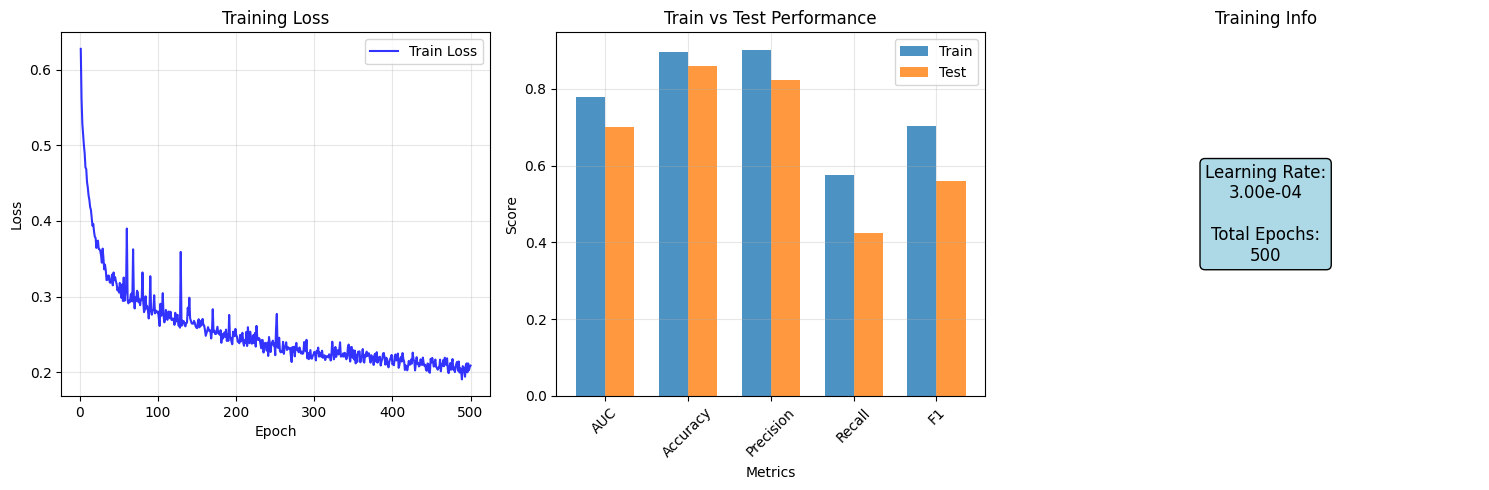

RESUMEN DEL ENTRENAMIENTO:
final_train_auc: 0.779647
final_train_accuracy: 0.897238
final_test_auc: 0.699906
final_test_accuracy: 0.858793
final_test_precision: 0.823529
final_test_recall: 0.424242
final_test_f1: 0.560000
total_epochs_trained: 500.000000
learning_rate: 0.000300


In [11]:
# --- Visualización de Resultados ---
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1: Training Loss
plt.subplot(1, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'b-', label='Train Loss', alpha=0.8)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Train vs Test Performance Comparison
plt.subplot(1, 3, 2)
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
train_metrics = [train_auc, train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_auc, test_accuracy, test_precision, test_recall, test_f1]

x = range(len(metrics))
width = 0.35

plt.bar([i - width/2 for i in x], train_metrics, width, label='Train', alpha=0.8)
plt.bar([i + width/2 for i in x], test_metrics, width, label='Test', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Train vs Test Performance')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Learning Rate Info
plt.subplot(1, 3, 3)
current_lr = optimizer.param_groups[0]['lr']
plt.text(0.5, 0.5, f'Learning Rate:\n{current_lr:.2e}\n\nTotal Epochs:\n{len(train_losses)}', 
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
plt.title('Training Info')
plt.axis('off')

plt.tight_layout()
plt.show()

# Guardar métricas en un resumen
training_summary = {
    'final_train_auc': train_auc,
    'final_train_accuracy': train_accuracy,
    'final_test_auc': test_auc,
    'final_test_accuracy': test_accuracy,
    'final_test_precision': test_precision,
    'final_test_recall': test_recall,
    'final_test_f1': test_f1,
    'total_epochs_trained': len(train_losses),
    'learning_rate': current_lr
}

print("RESUMEN DEL ENTRENAMIENTO:")
print("="*40)
for key, value in training_summary.items():
    print(f"{key}: {value:.6f}")
print("="*40)
